## Algorithm for automated trading (market-making at-the-touch)

This notebook implements a trading algorithm for automated market making. The model is specifically designed to work the limit orders at the best bid and offer only. 

### Business Logic:

The algrithm analyzes the order flow and orderbook and decides whether it should provide liquidity to the market. The internal decision making of the algorithm is based on dynamic programming principle for solving stochastic optimal control problem. At each time point $t$ the algorithm seeks to make decisions that maximise its "utility" at some future time $T$.

In the context of trading the utility may be represented as net monetary gain which results from participating in the liquidity provision of securities. Mathematically, the algorithm seeks to optimize the following objective:

\begin{align}
H(t,x,S_t,q) = \mathbb{E} \left[ \text{Payoff at time T} - \text{Total costs } | \mathcal{F}  \right] 
= \mathbb{E} \left[ X_T + Q_T \left(S_T-\left(\Delta + \alpha Q_T\right)\right) - \phi \int_{0}^{T}Q_{s}^{2}ds | \mathcal{F}  \right]
\end{align}

where $X_T$ represents the accrued proceeds from trading, $Q_T(S_T-(\Delta + \alpha Q_T))$ represents the liquidation value of the existing inventory of securities and $- \phi \int_{0}^{T}Q_{s}^{2}ds$ represents the total accrued running costs.

## Model 

The model is comprised of several mathematical "components" which all contribute to the final decision making logic.

#### Cash
The cash generated by the algorithm evolves according to:

\begin{align*}
    dX_t = \left(S_t + \Delta^{+} \right)l^{+} p_{t}^{+}dN_t^{+} + \left(S_t + \Delta^{-} \right)l^{-} p_{t}^{-}dN_t^{-}
\end{align*}


In [31]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np

from src.hjb_solvers import mm2_solve_h


## Model parameters

$\lambda^{-}$ = arrival rate for $\textbf{sell}$ market orders

$\lambda^{+}$ = arrival rate for $\textbf{buy}$ market orders

$\phi$ = running inventory penalty

$\alpha$ = terminal inventory penalty

$q_{max}$ = maximum long inventory

$q_{min}$ = maximum short inventory


In [30]:
T       = 1
lamda_m = 20
lamda_p = 20
alpha   = 0.001
phi     = 0.0001
q_min   = -20
q_max   =  20
N_steps = 250
delta   = 0.01

h,l_m,l_p,q_grid = mm2_solve_h(T,lamda_m,lamda_p,delta,alpha,phi,q_min,q_max,N_steps)


In [8]:
labels = {0:"Do nothing",1:"Buy",2:"Sell",3:"Buy and Sell"}
l      = np.zeros_like(l_p)
l[l_m==1] = 1
l[l_p==1] = 2
l[(l_p==1) & (l_m==1)] = 3

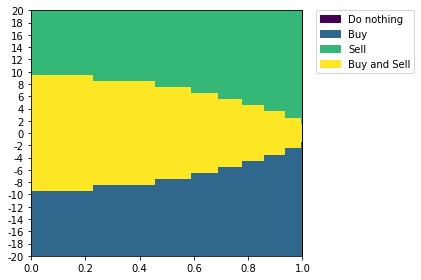

In [29]:


# Plot decisions
fig,ax = plt.subplots(figsize=(6,4))
im     = ax.imshow(l, aspect='auto')

# Configure vertical axis
ax.set_yticks(range(0,len(q_grid),2))
ax.set_yticklabels(q_grid[::2])

# Configure horizontal axis
t_grid = np.linspace(0,T,N_steps)
ax.set_xticks([i for i in range(0,N_steps)[::50]] + [N_steps])

ax.set_xticklabels(
        [np.round(t_grid[i],2) for i in range(0,N_steps)[::50]] + [np.round(t_grid[N_steps-1],2)]
        )

# Create labels
values  = np.unique(l.ravel())
colors  = [ im.cmap(im.norm(value)) for value in values]
labels  = {0:"Do nothing",1:"Buy",2:"Sell",3:"Buy and Sell"}
patches = [ mpatches.Patch(color=colors[i], label=labels[values[i]] ) for i in range(len(values)) ]
ax.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0. )
plt.tight_layout()
